In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os


In [2]:
Data_path = '/kaggle/input/plantvillage-dataset-labeled/PlantVillage Dataset (Labeled)/Individual Images/Apple'
os.listdir(os.path.join(Data_path))

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy']

In [3]:
batch_size = 32
img_height = 180
img_width = 180

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [5]:

Data = tf.keras.utils.image_dataset_from_directory(
  Data_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 799 files belonging to 4 classes.


In [6]:
class_names =Data.class_names
print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']


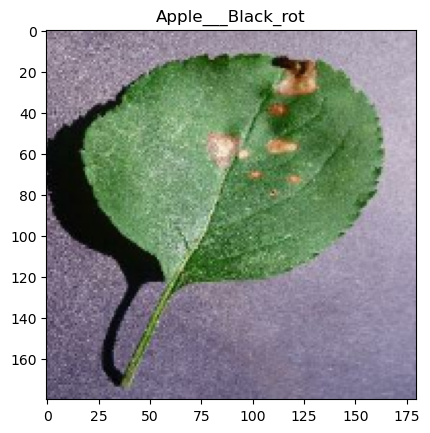

In [7]:
for img,label in Data.take(1):
    img = img.numpy().astype('uint')
    plt.imshow(img[0])
    plt.title(class_names[(label[0].numpy())])

In [8]:
size = len(Data)

# 25 batches into 80% as training, 10% as test and 10% as validation

In [9]:
train_size = int(0.8*size)
test_size = int(0.1*size)
validation_size = train_size - test_size
train_size

20

In [10]:
train = Data.take(train_size)
test = Data.skip(train_size).take(test_size)
val = Data.skip(train_size).skip(test_size)
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [11]:
train = train.cache().prefetch(tf.data.AUTOTUNE)
test = test.cache().prefetch(tf.data.AUTOTUNE)
val = val.cache().prefetch(tf.data.AUTOTUNE)

In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D,Rescaling


In [13]:
data_augmentation = Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomBrightness(0.2)]
)


In [14]:

num_classes = len(class_names)
model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [15]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [16]:
model.fit(train,validation_data=val,epochs=10)

Epoch 1/10
20/20 [==============================] - 21s 903ms/step - loss: 1.3405 - accuracy: 0.3672 - val_loss: 1.0462 - val_accuracy: 0.5263
Epoch 2/10
20/20 [==============================] - 17s 830ms/step - loss: 1.0003 - accuracy: 0.5984 - val_loss: 0.7849 - val_accuracy: 0.6737
Epoch 3/10
20/20 [==============================] - 17s 851ms/step - loss: 0.6635 - accuracy: 0.7750 - val_loss: 0.3428 - val_accuracy: 0.9053
Epoch 4/10
20/20 [==============================] - 17s 832ms/step - loss: 0.5788 - accuracy: 0.7656 - val_loss: 0.4307 - val_accuracy: 0.7895
Epoch 5/10
20/20 [==============================] - 17s 846ms/step - loss: 0.4935 - accuracy: 0.8281 - val_loss: 0.3685 - val_accuracy: 0.8526
Epoch 6/10
20/20 [==============================] - 17s 846ms/step - loss: 0.4209 - accuracy: 0.8359 - val_loss: 0.3305 - val_accuracy: 0.8947
Epoch 7/10
20/20 [==============================] - 16s 823ms/step - loss: 0.3908 - accuracy: 0.8531 - val_loss: 0.3687 - val_accuracy: 0.8737

In [17]:
model.evaluate(test)


2/2 [==============================] - 1s 189ms/step - loss: 0.3124 - accuracy: 0.8906


[0.3123871684074402, 0.890625]

In [18]:
len(test)

2

In [19]:
pred = []
for img,labels in test:
    pred.extend(model.predict(img))
    
len(pred)

1/1 [==============================] - 0s 195ms/step


64

In [20]:
label = []
for img,labels in test:
    label.extend(labels.numpy())
len(label)

64

In [21]:
pred_labels = []
for prob in pred:
    pred_labels.append(np.argmax(prob))
len(pred_labels)

64

In [22]:
from sklearn.metrics import classification_report
print(classification_report(label,pred_labels))

              precision    recall  f1-score   support

           0       1.00      0.58      0.74        12
           1       0.92      0.96      0.94        23
           2       1.00      0.94      0.97        16
           3       0.72      1.00      0.84        13

    accuracy                           0.89        64
   macro avg       0.91      0.87      0.87        64
weighted avg       0.91      0.89      0.89        64

